In [48]:
import numpy as np
import torch
import SimpleITK as sitk
import json
import os
from pathlib import Path
from UNet_channels_Clifford import CliffordEmbeddingBlock, CliffordEmbeddingUNet
from monai.transforms import (
    Activations,
    AsDiscrete,
    LoadImage,
    Resize,
    Compose,
    EnsureChannelFirst,
    Spacing
)

In [2]:
def resample_sitk(image_sitk, new_spacing=None, new_size=None,
                   interpolator=sitk.sitkLinear, tol=0.00001):
    # Get original settings
    original_size = image_sitk.GetSize()
    original_spacing = image_sitk.GetSpacing()
   
    # ITK can only do 3D images
    if len(original_size) == 2:
        original_size = original_size + (1, )
    if len(original_spacing) == 2:
        original_spacing = original_spacing + (1.0, )

    if new_size is None:
        # Compute output size
        new_size = [round(original_size[0]*(original_spacing[0] + tol) / new_spacing[0]),
                    round(original_size[1]*(original_spacing[0] + tol) / new_spacing[1]),
                    round(original_size[2]*(original_spacing[2] + tol) / new_spacing[2])]

    if new_spacing is None:
        # Compute output spacing
        tol = 0
        new_spacing = [original_size[0]*(original_spacing[0] + tol)/new_size[0],
                       original_size[1]*(original_spacing[0] + tol)/new_size[1],
                       original_size[2]*(original_spacing[2] + tol)/new_size[2]]

    # Set and execute the filter
    ResampleFilter = sitk.ResampleImageFilter()
    ResampleFilter.SetInterpolator(interpolator)
    ResampleFilter.SetOutputSpacing(new_spacing)
    ResampleFilter.SetSize(np.array(new_size, dtype='int').tolist())
    ResampleFilter.SetOutputDirection(image_sitk.GetDirection())
    ResampleFilter.SetOutputOrigin(image_sitk.GetOrigin())
    ResampleFilter.SetOutputPixelType(image_sitk.GetPixelID())
    ResampleFilter.SetTransform(sitk.Transform())
    try:
        resampled_image_sitk = ResampleFilter.Execute(image_sitk)
    except RuntimeError:
        # Assume the error is due to the direction determinant being 0
        # Solution: simply set a correct direction
        # print('Bad output direction in resampling, resetting direction.')
        direction = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
        ResampleFilter.SetOutputDirection(direction)
        image_sitk.SetDirection(direction)
        resampled_image_sitk = ResampleFilter.Execute(image_sitk)

    return resampled_image_sitk


In [3]:
import matplotlib.pyplot as plt
def get_image_orientation_from_direction(img_sitk):
    """
    img_sitk = SimpleITK image
    return string orientation
    """
    filter = sitk.DICOMOrientImageFilter()
    filter.Execute(img_sitk)
    orientation = filter.GetOrientationFromDirectionCosines(img_sitk.GetDirection())
    return orientation

def plot_box(image_sitk, patient_id, display_slices=None):
    """Plots 2D views of an MRI image, with mask_sitk giving info on slice to display"""
    
    # Get image spacing and orientation
    orientation = get_image_orientation_from_direction(image_sitk)

        # Define slice locations for display
    if display_slices is None:
        # Default to the middle slice along each axis of the bounding box containing the mask
        x_max, y_max, z_max =  sitk.Image.GetSize(image_sitk)
        display_slices = [x_max // 2, y_max // 2, z_max // 2]

    # Convert images to NumPy arrays
    image_array = sitk.GetArrayFromImage(image_sitk)

    # Extract 2D slices for each view
    slice_xy = image_array[:, :, display_slices[0]]
    slice_xz = image_array[:, display_slices[1], :]
    slice_yz = image_array[display_slices[2], :, :]
    # Plot 2D views with contours
    fig, ax = plt.subplots(1, 3, figsize=(5 , 5))
    fig.suptitle(f"Patient ID: {patient_id}", fontsize=12)
    
    ax[0].imshow(slice_xy, cmap='gray')
    ax[1].imshow(slice_xz, cmap='gray')
    ax[2].imshow(slice_yz, cmap='gray')

    # Set titles and invert y-axis for radiological view
    view_titles = ["Sagittal", "Coronal", "Axial"] if orientation == 'LAI' else ["Coronal", "Axial", "Sagittal"]
    for i, title in enumerate(view_titles):
        ax[i].set_title(title, fontweight="bold")
        ax[i].invert_yaxis()
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_aspect('equal')

    fig.tight_layout()
    plt.show()
    
def plot_3d_segmentation(mask_sitk):
    orientation = get_image_orientation_from_direction(mask_sitk)
    if orientation == 'LAI':
        mask_array = sitk.GetArrayFromImage(mask_sitk).transpose(1, 2, 0)
    else:
        mask_array = sitk.GetArrayFromImage(mask_sitk)
    color_list = ['#E15759']
    ax = plt.figure().add_subplot(projection='3d')
    ax.voxels(mask_array, facecolors=color_list[0], edgecolor='k')
    plt.tight_layout()
    plt.show()

def resample_sitk(image_sitk, new_spacing=None, new_size=None,
                   interpolator=sitk.sitkLinear, tol=0.00001):
    # Get original settings
    original_size = image_sitk.GetSize()
    original_spacing = image_sitk.GetSpacing()
   
    # ITK can only do 3D images
    if len(original_size) == 2:
        original_size = original_size + (1, )
    if len(original_spacing) == 2:
        original_spacing = original_spacing + (1.0, )

    if new_size is None:
        # Compute output size
        new_size = [round(original_size[0]*(original_spacing[0] + tol) / new_spacing[0]),
                    round(original_size[1]*(original_spacing[0] + tol) / new_spacing[1]),
                    round(original_size[2]*(original_spacing[2] + tol) / new_spacing[2])]

    if new_spacing is None:
        # Compute output spacing
        tol = 0
        new_spacing = [original_size[0]*(original_spacing[0] + tol)/new_size[0],
                       original_size[1]*(original_spacing[0] + tol)/new_size[1],
                       original_size[2]*(original_spacing[2] + tol)/new_size[2]]

    # Set and execute the filter
    ResampleFilter = sitk.ResampleImageFilter()
    ResampleFilter.SetInterpolator(interpolator)
    ResampleFilter.SetOutputSpacing(new_spacing)
    ResampleFilter.SetSize(np.array(new_size, dtype='int').tolist())
    ResampleFilter.SetOutputDirection(image_sitk.GetDirection())
    ResampleFilter.SetOutputOrigin(image_sitk.GetOrigin())
    ResampleFilter.SetOutputPixelType(image_sitk.GetPixelID())
    ResampleFilter.SetTransform(sitk.Transform())
    try:
        resampled_image_sitk = ResampleFilter.Execute(image_sitk)
    except RuntimeError:
        # Assume the error is due to the direction determinant being 0
        # Solution: simply set a correct direction
        # print('Bad output direction in resampling, resetting direction.')
        direction = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
        ResampleFilter.SetOutputDirection(direction)
        image_sitk.SetDirection(direction)
        resampled_image_sitk = ResampleFilter.Execute(image_sitk)

    return resampled_image_sitk

In [47]:
device = torch.device('cuda:1')
block = CliffordEmbeddingBlock(
algebra_metric=[-1],
embedding_indices=[0, 1],
weight_blade_indices=torch.tensor([0, 1]).to(device),
real_reduction=lambda x: torch.mean(x, dim=-1),
# TODO get for general input
embedding_length=65536,
depth=1,
).to(device)
model = CliffordEmbeddingUNet(
    channel_count=len([0, 1]),
    clifford_embedding_block=block,
    channel_list=(16, 32, 64, 128),
).to(device)
# === Load your trained model from a specific fold ===
model.load_state_dict(torch.load("best_metric_model_channels[0, 1]_algebra_[-1]_embedding_[0, 1]_weights_[0, 1]_depth_1_resize_[128, 128, 128].pth",weights_only=True))
model.eval()
threshold = AsDiscrete(threshold=0.5)
sigmoid = Activations(sigmoid=True)

transforms = Compose(
        [
            # LoadImage(),
            # EnsureChannelFirst(),
            Spacing((1, 1, 1)),
            Resize(spatial_size=[128, 128, 128])
        ]
    )

ids = np.load("/home/romanuccio/RomanuccioDiff/MAMAMIA_Challenge/train_ids_v_pojeb.npy", allow_pickle=True)
# for id in ids[:20]:
#     filepath = id/(id.stem + '_0001' + '.nii.gz')
#     # print(id)
#     transed = transforms(filepath)
#     print(transed.shape)


In [58]:
# import numpy as np
# import nibabel as nib  # Assuming your transform involves loading .nii.gz
# from pathlib import Path
# import numpy as np

# # Load the IDs (likely Paths or strings)
# ids = np.load("/home/romanuccio/RomanuccioDiff/MAMAMIA_Challenge/train_ids_v_pojeb.npy", allow_pickle=True)

# shapes = []

# for id in ids:
#     id = Path(id)  # Ensure it's a Path object
#     filepath = id / (id.stem + '_0001.nii.gz')

#     # Apply your transform (replace with actual transform function)
#     transed = transforms(filepath)  # Assuming it returns a numpy array

#     shapes.append(transed.shape)

# # Convert to numpy array of shape (N, dims...)
# shape_array = np.array(shapes)

# # Calculate average and median shape
# avg_shape = np.mean(shape_array, axis=0)
# med_shape = np.median(shape_array, axis=0)

# print("Average shape:", avg_shape)
# print("Median shape:", med_shape)


In [ ]:
from monai.transforms import RandAffined

In [57]:
patient_ids = ['DUKE_107','DUKE_002','DUKE_005','ISPY1_1128','ISPY1_1137', 'ISPY2_179369', 'ISPY2_225836', 'ISPY2_263143', 'NACT_50', 'NACT_60']

resizer = Resize(spatial_size=[128, 128, 128])
# channels = [0, 1]
output_dir = 'asdf'
# === Final output folder (MANDATORY name) ===
output_dir_final = os.path.join(output_dir, 'pred_segmentations')
os.makedirs(output_dir_final, exist_ok=True)

for patient_id in patient_ids:
    json_path = Path("/home/romanuccio/RomanuccioDiff/patient_info_files")
    json_path = json_path/(patient_id+'.json')
    # get bounding box from json
    with open(json_path, "r") as file:
        try:
            data = json.load(file)
            coords = data.get("primary_lesion", {}).get("breast_coordinates", {})

            required_keys = ["x_min", "x_max", "y_min", "y_max", "z_min", "z_max"]
            if not all(key in coords for key in required_keys):
                print(f"Missing coordinates in {json_path}")
                
            x_min, x_max = coords["x_min"], coords["x_max"]
            y_min, y_max = coords["y_min"], coords["y_max"]
            z_min, z_max = coords["z_min"], coords["z_max"]

        except json.JSONDecodeError as e:
            print(f"Error decoding {json_path}: {e}")
            
    ### get data
    images_folder = Path('/home/romanuccio/RomanuccioDiff/images')
    # trained_cropped = Path('/home/romanuccio/RomanuccioDiff/MAMAMIA_Challenge/cropped_by_json_resampled')/patient_id/f'{patient_id}_0001.nii.gz'
    # trained_box = sitk.ReadImage(trained_cropped) 
    
    image_path0 = images_folder/patient_id/f'{patient_id}_0000.nii.gz'
    image_path1 = images_folder/patient_id/f'{patient_id}_0001.nii.gz'
    # plot_box(trained_box, 'training box')
    
    
    ### read raw image
    raw_image0 = sitk.ReadImage(image_path0) #read the image, it's W H D
    raw_image1 = sitk.ReadImage(image_path1) #read the image, it's W H D
    # raw_shape = (raw_image1.GetWidth(), raw_image1.GetHeight(), raw_image1.GetDepth())
    
    ### bounding box extraction
    start_index = (z_min, y_min, x_min) # bounding box is in NP/torch format D H W => have to reverse order
    size = (z_max - z_min, y_max - y_min, x_max - x_min)
    
    box0 = sitk.Extract(raw_image0, size, start_index)
    box0_shape = box0.GetSize()
    box0 = resample_sitk(box1, new_spacing=(1,1,1))
    
    box1 = sitk.Extract(raw_image1, size, start_index)
    box1_shape = box1.GetSize()
    box1 = resample_sitk(box1, new_spacing=(1,1,1))
    
    ### moving down to model input level
    box_array0 = torch.tensor(sitk.GetArrayFromImage(box0)).to(device)[None, ...]
    box_array0 = box_array0.transpose(1, 3)
    image0 = transforms(box_array0)[None, ...]
    
    box_array1 = torch.tensor(sitk.GetArrayFromImage(box1)).to(device)[None, ...]
    box_array1 = box_array1.transpose(1, 3)
    image1 = transforms(box_array1)[None, ...]
    
    ### obtain segmentation
    input_image = torch.cat((image0, image1), dim=1)
    seg = threshold(sigmoid(model(input_image)))
    seg = seg[:, 1:2, ...]
    seg = torch.round(seg).to(torch.uint8)
    
    ### resize to extracted bounding box dimensions back from model dimensions
    box_resize = Resize(box1_shape, mode='nearest')
    seg = box_resize(seg[0, ...])
    seg = seg[0, ...]
    seg = seg.int()
    seg = seg.detach().cpu()
    
    ### sitk fuckery
    zero_image = sitk.Image(raw_image1.GetSize(), raw_image1.GetPixelID())
    zero_array = sitk.GetArrayFromImage(zero_image)
    zero_array[x_min:x_max, y_min:y_max, z_min:z_max] = seg.transpose(0, 2)
    zero_image = sitk.GetImageFromArray(zero_array)
    zero_image.SetSpacing(raw_image1.GetSpacing())
    zero_image.SetOrigin(raw_image1.GetOrigin())
    zero_image.SetDirection(raw_image1.GetDirection())
    zero_image.SetSpacing(raw_image1.GetSpacing())

    # sitk.WriteImage(zero_image, f'segmentation_upscaled{patient_id}.nii.gz')
    
    sitk.WriteImage(zero_image, f'segmentation_in_raw_space_{patient_id}.nii.gz')

`data_array` is not of type MetaTensor, assuming affine to be identity.


extracting box of size [221, 354, 157] indexed at [224, 5, 1] from image of size (448, 448, 160), (448, 448, 160)


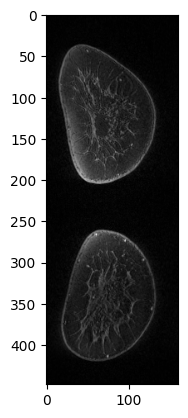

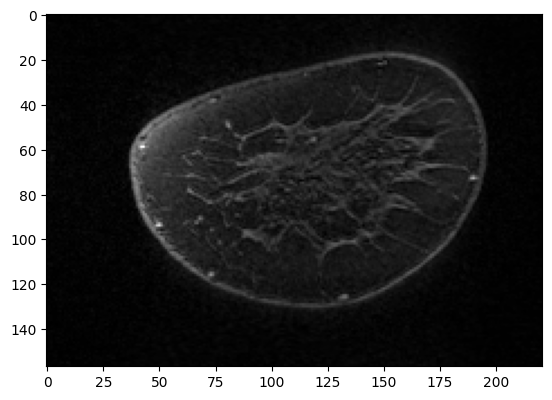

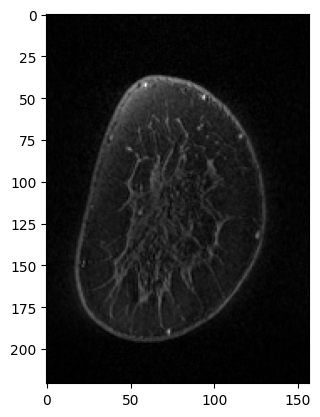

(torch.Size([448, 448, 160]), (448, 448, 160), (160, 448, 448))

In [ ]:
patient_id = 'DUKE_001'
json_path = f'/home/romanuccio/RomanuccioDiff/patient_info_files/{patient_id}.json'
with open(json_path, "r") as file:
    data = json.load(file)
    coords = data.get("primary_lesion", {}).get("breast_coordinates", {})
    x_min, x_max = coords["x_min"], coords["x_max"]
    y_min, y_max = coords["y_min"], coords["y_max"]
    z_min, z_max = coords["z_min"], coords["z_max"]
    
    size_x = x_max - x_min
    size_y = y_max - y_min
    size_z = z_max - z_min
    
    start_index = [z_min, y_min, x_min]
    size = [size_z, size_y, size_x]

reader = LoadImage()
path = f'/home/romanuccio/RomanuccioDiff/images/{patient_id}/{patient_id}_0001.nii.gz'
img = sitk.ReadImage(path)
img_size = (img.GetWidth(), img.GetHeight(), img.GetDepth())
print(f'extracting box of size {size} indexed at {start_index} from image of size {img_size}')
box1 = sitk.Extract(img, size, start_index)
box1_data = sitk.GetArrayFromImage(box1)
plt.imshow(sitk.GetArrayFromImage(img).transpose()[:,250+y_min,:], cmap='gray')
plt.show()
plt.imshow(box1_data[:,250,:], cmap='gray')
plt.show()
plt.imshow(box1_data.transpose()[:,250,:], cmap='gray')
plt.show()
reader(path).shape, img_size, sitk.GetArrayFromImage(img).shape

In [ ]:

    
    # # Convert seg tensor to numpy
    # seg_array = seg.cpu().numpy()[0, 0, ...]  # D,H,W

    # # Make sure array axes order match SimpleITK expected order
    # seg_sitk = sitk.GetImageFromArray(seg_array)

    # # Assign spatial info from box (cropped image)
    # seg_sitk.SetSpacing(box.GetSpacing())
    # seg_sitk.SetOrigin(box.GetOrigin())
    # seg_sitk.SetDirection(box.GetDirection())

    # # Resample seg mask to raw image space
    # resampler = sitk.ResampleImageFilter()
    # resampler.SetReferenceImage(raw_image)
    # resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    # resampled_seg = resampler.Execute(seg_sitk)


    # sitk.WriteImage(resampled_seg, f'segmentation_in_raw_space_{patient_id}.nii.gz')

    
    # # Convert seg (Torch tensor) back to SITK image
    # seg_array = seg.detach().cpu().numpy()[0,0,...]  # remove batch dimension
    # seg_array = seg_array.transpose(2, 1, 0)   # convert back to (z, y, x) for SITK
    # seg_image = sitk.GetImageFromArray(seg_array)
    # seg_image.SetSpacing(box.GetSpacing())
    # seg_image.SetOrigin(box.GetOrigin())
    # seg_image.SetDirection(box.GetDirection())

    # # Resample segmentation back to cropped box's original spacing
    # # (if you downsampled box earlier)
    # # If box was already resampled to spacing=(1,1,1), skip this step
    # # Resample segmentation back to original box spacing (before any isotropic resampling)
    # resample = sitk.ResampleImageFilter()
    # resample.SetOutputSpacing(box.GetSpacing())
    # resample.SetSize(box.GetSize())  # This should be the original cropped box's size
    # resample.SetOutputOrigin(box.GetOrigin())
    # resample.SetOutputDirection(box.GetDirection())
    # resample.SetInterpolator(sitk.sitkNearestNeighbor)  # Important for segmentation
    # resample.SetDefaultPixelValue(0)

    # # Apply resampling
    # seg_image = resample.Execute(seg_image)


    # # Paste segmentation back into the full raw_image-sized blank volume
    # blank = sitk.Image(raw_image.GetSize(), sitk.sitkUInt8)  # or s.t. matching seg dtype
    # blank.SetSpacing(raw_image.GetSpacing())
    # blank.SetOrigin(raw_image.GetOrigin())
    # blank.SetDirection(raw_image.GetDirection())

    # # Convert start_index from (z, y, x) to (x, y, z) for SITK
    # paste_index = (start_index[2], start_index[1], start_index[0])
    # seg_image = sitk.Cast(seg_image, sitk.sitkUInt8)

    # # Paste the seg_image into the blank image
    # blank = sitk.Paste(destinationImage=blank, sourceImage=seg_image,
    #                 sourceSize=seg_image.GetSize(),
    #                 destinationIndex=paste_index)

    # # Save the final segmentation
    # sitk.WriteImage(blank, f'segmentation_in_raw_space_{patient_id}.nii.gz')

    
    
#     print(f'itsokay seg {seg.shape}')
#     seg_sitk = sitk.GetImageFromArray(seg[0,0,...].detach().cpu())
#     sitk.WriteImage(seg_sitk, 'raw_output_segmentation.nii.gz')
#     vis.plot_mri_and_segmentation(image_sitk, seg_sitk, 'model output on input')
#     print(f'{seg.shape} shape of model output')
    
#     # upsizer needs channel dim
#     seg = seg[0, ...]
#     seg = seg.transpose(1, 3)
#     seg = upsizer(seg.detach().cpu())
#     # get rid of batch dim
#     seg = seg[0, ...]
    
#     seg_sitk = sitk.GetImageFromArray(seg.detach().cpu())
    
#     resampled_test = sitk.Resample(
#     image1=seg_sitk,
#     referenceImage=raw_image,
#     transform=sitk.Transform(),  # Identity transform
#     interpolator=sitk.sitkNearestNeighbor,  # Use sitk.sitkNearestNeighbor for binary masks
#     defaultPixelValue=0,
#     outputPixelType=seg_sitk.GetPixelID()
# )
#     print(f'testing : W: {resampled_test.GetWidth()} H: {resampled_test.GetHeight()}, D: {resampled_test.GetDepth()}')
#     sitk.WriteImage(resampled_test, 'romanuccio.nii.gz')
    
    
#     sitk.WriteImage(seg_sitk, 'first_error.nii.gz')
#     seg_sitk.CopyInformation(sitk.PermuteAxes(raw_image,(2, 1, 0)))
#     sitk.WriteImage(seg_sitk, 'first_error_informed.nii.gz')
#     # sitk.WriteImage(sitk.PermuteAxes(seg_sitk, ()), 'first_error_transposed.nii.gz')
#     print(f'after upsize {seg.shape}')
    
#     # seg = seg.transpose(0, 1)
#     print(seg.dtype)
#     imgseg = sitk.GetImageFromArray(seg.int())
#     imgseg.CopyInformation(sitk.PermuteAxes(raw_image, (2, 1, 0)))
#     sitk.WriteImage(imgseg, 'resized_segmentation.nii.gz')
    
    
    # vis.plot_mri_and_segmentation(raw_image, blank, 'ahoj')
    # print(f'final shape: {imgseg.GetDepth(), imgseg.GetHeight(), imgseg.GetWidth()}')
    # plot_box(raw_image, patient_id)
    # plot_box(sitk.GetImageFromArray(image.detach().cpu()[0,0,...].transpose(0,2)), patient_id)
    # plot_box(imgseg, patient_id)
    
    
    # image = sitk.GetImageFromArray(image[0,...])
    # plot_box(image, patient_id)
    # print(f"image shape: {image.GetWidth(), image.GetHeight(), image.GetDepth()}")

In [ ]:
patient_ids = ['DUKE_107']#,'DUKE_002','DUKE_005','ISPY1_1128','ISPY1_1137', 'ISPY2_179369', 'ISPY2_225836', 'ISPY2_263143', 'NACT_50', 'NACT_60']
model.eval()
threshold = AsDiscrete(threshold=0.5)
sigmoid = Activations(sigmoid=True)

import os
output_dir = 'asdf'
# === Final output folder (MANDATORY name) ===
output_dir_final = os.path.join(output_dir, 'pred_segmentations')
os.makedirs(output_dir_final, exist_ok=True)

for patient_id in patient_ids:
    json_path = Path("/home/romanuccio/RomanuccioDiff/patient_info_files")
    json_path = json_path/(patient_id+'.json')
    # get bounding box from json
    with open(json_path, "r") as file:
        try:
            data = json_path.load(file)
            coords = data.get("primary_lesion", {}).get("breast_coordinates", {})

            required_keys = ["x_min", "x_max", "y_min", "y_max", "z_min", "z_max"]
            if not all(key in coords for key in required_keys):
                print(f"Missing coordinates in {json_path}")
                
            
            x_min, x_max = coords["x_min"], coords["x_max"]
            y_min, y_max = coords["y_min"], coords["y_max"]
            z_min, z_max = coords["z_min"], coords["z_max"]
            
            print(f"bound box: depth(x) {x_max - x_min} height(y) {y_max - y_min} height(z) {z_max - z_min}")

        except json_path.JSONDecodeError as e:
            print(f"Error decoding {json_path}: {e}")


    # get data
    images_folder = Path('/home/romanuccio/RomanuccioDiff/images')
    image_path1 = images_folder/patient_id/f'{patient_id}_0001.nii.gz'
    raw_image1 = sitk.ReadImage(image_path1)
    print(f"raw_image shape: {raw_image1.GetWidth(), raw_image1.GetHeight(), raw_image1.GetDepth()}")
    image1 = sitk.GetArrayFromImage(raw_image1)
    image_shape = image1.shape
    image1 = image1[x_min:x_max, y_min:y_max, z_min:z_max]
    image1 = sitk.GetImageFromArray(image1)
    image1 = resample_sitk(
        image1, new_size=[256, 256, 128], interpolator=sitk.sitkLinear
    )
    sitk.WriteImage(image1, 'original_image.nii.gz')
    
    # transf = LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)
    image1 = sitk.GetArrayFromImage(image1)
    image1 = image1.transpose()[None, None, ...]
    image1 = torch.tensor(image1, dtype=torch.float).to(device)
    
    pred = model(image1)
    pred = threshold(sigmoid(pred))
    sitk.WriteImage(sitk.GetImageFromArray(pred.detach().cpu()), 'fucking.nii.gz')
    pred = pred[0, 0, ...]
    
    # plot_box(sitk.GetImageFromArray(pred.cpu()), 'ahoj', (15, 15, 10))
    
    print(f"pred shape: {pred.shape}")
    
    # properly rescale prediction
    pred_sitk = sitk.GetImageFromArray(torch.Tensor.numpy(pred.cpu()))
    print(f"pred_sitk shape pre resample: {pred_sitk.GetWidth(), pred_sitk.GetHeight(), pred_sitk.GetDepth()}")
    pred_sitk = resample_sitk(pred_sitk, new_size = [x_max - x_min, y_max - y_min, z_max - z_min], interpolator=sitk.sitkNearestNeighbor)
    print(f"pred_sitk shape post resample: {pred_sitk.GetWidth(), pred_sitk.GetHeight(), pred_sitk.GetDepth()}")
    
    # plot_3d_segmentation(pred_sitk)
    
    # pred sitk now has shape of unrescaled bounding box
    # prepare empty image with original image size to fill in with prediction
    # numpy shape format
    empty_pred = torch.zeros((raw_image1.GetWidth(), raw_image1.GetHeight(), raw_image1.GetDepth()))
    print(f"empty_pred shape: {empty_pred.shape}")
    # empty_pred[z_min:z_max, y_min:y_max, x_min:x_max] = torch.tensor(sitk.GetArrayFromImage(pred_sitk))
    empty_pred[x_min:x_max, y_min:y_max, z_min:z_max] = torch.tensor(sitk.GetArrayFromImage(pred_sitk))
    empty_pred = empty_pred.transpose(0, 2)
    segmentation = sitk.GetImageFromArray(empty_pred)
    # segmentation.CopyInformation(raw_image)
    print(f"final segmentation shape: {segmentation.GetWidth(), segmentation.GetHeight(), segmentation.GetDepth()}")
    # MANDATORY: the segmentation masks should be named using the patient_id
    final_seg_path = os.path.join(output_dir_final, f"{patient_id}.nii.gz")
    # print(final_seg_path)
    sitk.WriteImage(segmentation, final_seg_path)
    
    
raw_image1

bound box: depth(x) 193 height(y) 431 height(z) 249
raw_image shape: (512, 512, 196)
pred shape: torch.Size([256, 256, 128])
pred_sitk shape pre resample: (128, 256, 256)
pred_sitk shape post resample: (193, 431, 249)
empty_pred shape: torch.Size([512, 512, 196])


RuntimeError: The expanded size of the tensor (189) must match the existing size (193) at non-singleton dimension 2.  Target sizes: [193, 431, 189].  Tensor sizes: [249, 431, 193]

In [ ]:
images_folder = Path('/home/romanuccio/RomanuccioDiff/MAMAMIA_Challenge/cropped_by_json_resampled')
patient_ids = 'DUKE_107'
image_path1 = images_folder/patient_id/f'{patient_id}_0001.nii.gz'
raw_image1 = sitk.ReadImage(image_path1)
raw_image1 = resample_sitk(
    raw_image1, new_size=[256, 256, 128], interpolator=sitk.sitkLinear
)
image1 = sitk.GetArrayFromImage(raw_image1).transpose()
image1 = image1[None, None, ...]
image1 = torch.tensor(image1, dtype=torch.float).to(device)
pred = model(image1)
pred = threshold(sigmoid(pred))

# pred.shape

sitk.WriteImage(sitk.GetImageFromArray(pred[0,0,...].detach().cpu()),'fucking_duke_107_output_from_training.nii.gz')

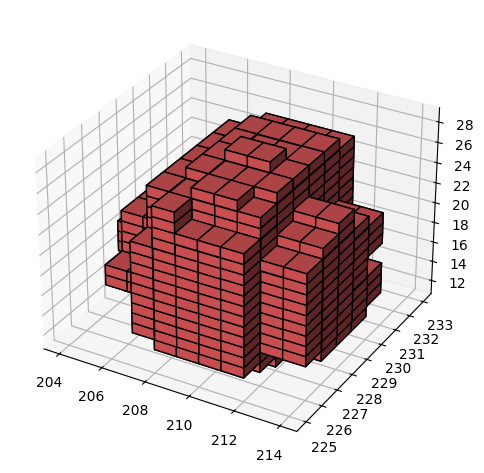

In [97]:
plot_3d_segmentation(segmentation)

In [57]:
x_min, x_max, y_min, y_max, z_min, z_max

(1, 158, 5, 359, 224, 445)